# Buffer Reconstruction

We use the logfile to reconstruct the timestamp of the NONVETO (or any buffer for that matter) using the logfile from the end, once we know that we have downloaded all the data

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, IndexLocator
import raadpy as rp
import numpy as np
from scipy.signal import savgol_filter
import os

# Define some constants
raw_dir = '../../Data/FULL_DATA/'
# raw_dir = '../../Data/TAIL/'
# SD      = '2022-09-19' 
# raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)
%matplotlib widget

{'buff1': 'light1-2022-03-04-buff1.dat', 'buff2': 'light1-2022-08-04-buff2.dat', 'buff3': 'light1-2022-08-02-buff3.dat', 'buff4': 'light1-2022-03-04-buff4.dat', 'buff5': 'light1-2022-03-04-buff5.dat', 'buff6': 'light1-2022-03-08-buff6.dat', 'buff7': 'light1-2022-03-08-buff7.dat', 'log': 'light1-se-log.txt'}


In [2]:
# data = rp.get_dict(raw_dir+filenames['buff3'],struct=rp.TGF_STRUCT,VERIFY=True,STUPID=False,threshold=1e10,LAST=4000000)
# data = rp.get_dict(raw_dir+filenames['buff5'],struct=rp.NONVETO_STRUCT,VERIFY=True,STUPID=True,threshold=4*1e6,LAST=4000000)
data = rp.get_dict(raw_dir+filenames['buff4'],struct=rp.NONVETO_STRUCT,VERIFY=True,STUPID=True,threshold=4*1e6,LAST=4000000)
# data = rp.get_dict(raw_dir+filenames['buff7'],struct=rp.VETO_STRUCT,VERIFY=True,STUPID=True,threshold=3*1e7,LAST=4000000)
# data = rp.subdict(data,int(1.16e6))

Line:   0%|          | 0/4000000 [00:00<?, ?it/s]

Bit Flipper:   0%|          | 0/3999999 [00:00<?, ?it/s]

Line:   0%|          | 0/4000000 [00:00<?, ?it/s]

Bit Flipper:   0%|          | 0/3999999 [00:00<?, ?it/s]

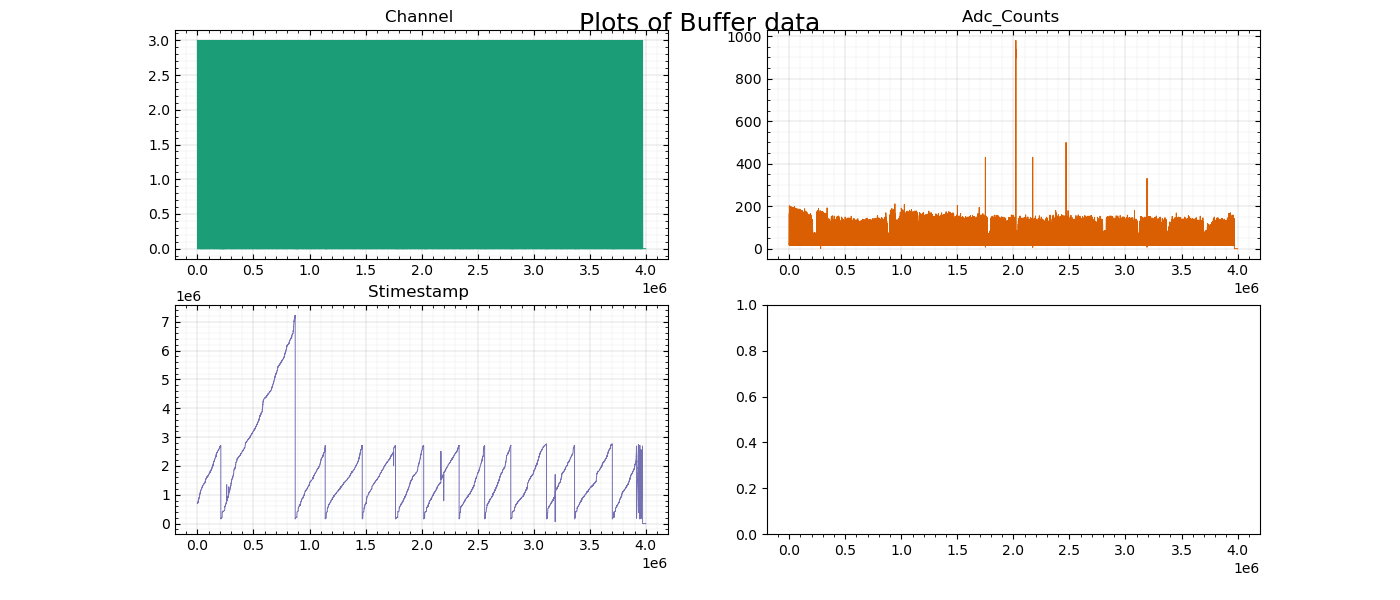

In [3]:
rp.plot_buffer(data);

In [4]:
# Clip the data to the regions of interest
TAIL = 10000

# Now we load the log file and find it's timestamps
log     = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log     = log[-TAIL:]
log     = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing

In [5]:
# Helper functions #############################################

# Get the two arrays of different size and match their elements
def match(*arrays,from_end=True):
    # Length of the final arrays
    length = min([len(array) for array in arrays])

    # Concatenate the arrays
    if from_end:
        return [array[-length:] for array in arrays]
    else: 
        return [array[:length] for array in arrays]

# Collect timestamps of command execution
def collect_time_cmd(log:dict,cmd,include_end:bool=True):
    return np.array([line['timestamp'] for line in log if cmd in line['command']])

# Remove the dublicates
def remove_duplicates(array,mean:float=1,std:float=1,return_idx:bool=False,only_zeros:float=float('inf')):
    diff    = array[1:] - array[:-1]
    idx     = np.where(diff > mean*np.mean(diff) + std*np.std(diff))[0]
    idx     = np.array([i for i in idx if abs(array[i+1]) <= only_zeros])

    if return_idx: return idx
    return array[idx]

# Take an array and return an increasing version of it
def force_increasing(array):
    add     = 0
    output  = array.copy()
    for i in range(1,len(array)):
        if array[i] - array[i-1] < 0: add += array[i-1]
        output[i] += add

    return output

In [6]:
# Find the peaks in the timestamp
end_timestamps_idx      = remove_duplicates(-data['stimestamp'],std=200,return_idx=True)           # Array of indices of the peaks
# end_timestamps_idx      = np.append(end_timestamps_idx,[len(data['stimestamp']) - 1])                    # Append the last index because it is a peak
start_timestamps_idx    = end_timestamps_idx[:-1] + 1

# Find the peaks in the logfile
PWR_ON_CMD              = 'txrx 4 14 600 0007010100'
PWR_OFF_CMD             = 'txrx 4 14 600 0007000000'
end_timestamps_log      = collect_time_cmd(log,PWR_OFF_CMD)
start_timestamps_log    = collect_time_cmd(log,PWR_ON_CMD)

In [7]:
# Match the two arrays from the back
end_timestamps_idx, end_timestamps_log, start_timestamps_idx, start_timestamps_log = match(end_timestamps_idx,end_timestamps_log,start_timestamps_idx,start_timestamps_log)

In [8]:
# Fill in the gaps in the logfile
from math import isnan
# Nomralize the logfile
normed_timestamps = data['stimestamp'].copy().astype('float')
# mean_max_timestamp = np.mean(data['stimestamp'][end_timestamps_idx])

# Normalize by tooth
for s,e in zip(start_timestamps_idx,end_timestamps_idx):
    normed_timestamps[s:e+1]    = normed_timestamps[s:e+1]
    # idx = np.where(normed_timestamps[s:e+1] > 3*mean_max_timestamp)[0]
    # if len(idx) > 0: normed_timestamps[idx] = 3*mean_max_timestamp
    temp_timestamp              = data['stimestamp'][s:e+1]
    if float(temp_timestamp[-1]-temp_timestamp[0]) == 0: print(temp_timestamp[-1],temp_timestamp[0],s,e)
    normed_timestamps[s:e+1]    = (normed_timestamps[s:e+1]- min(normed_timestamps[s:e+1]))/float(temp_timestamp[-1]-temp_timestamp[0])

# Finaly get the stupid timestamp
timestamp = []

# For each tooth
for i,(s,e) in enumerate(zip(start_timestamps_idx,end_timestamps_idx)):
    # For each element within the tooth
    min_time = start_timestamps_log[i]
    max_time = min(end_timestamps_log[i],min_time+3*60*60)
    for j in range(s,e+1):
        timestamp.append(normed_timestamps[j]*(max_time-min_time) + min_time)
        # if isnan(timestamp[-1]):
        #     print(normed_timestamps[j],(max_time-min_time), min_time)


timestamp = np.array(timestamp)

Text(0.5, 0.98, 'Reconstructed Time vs event number')

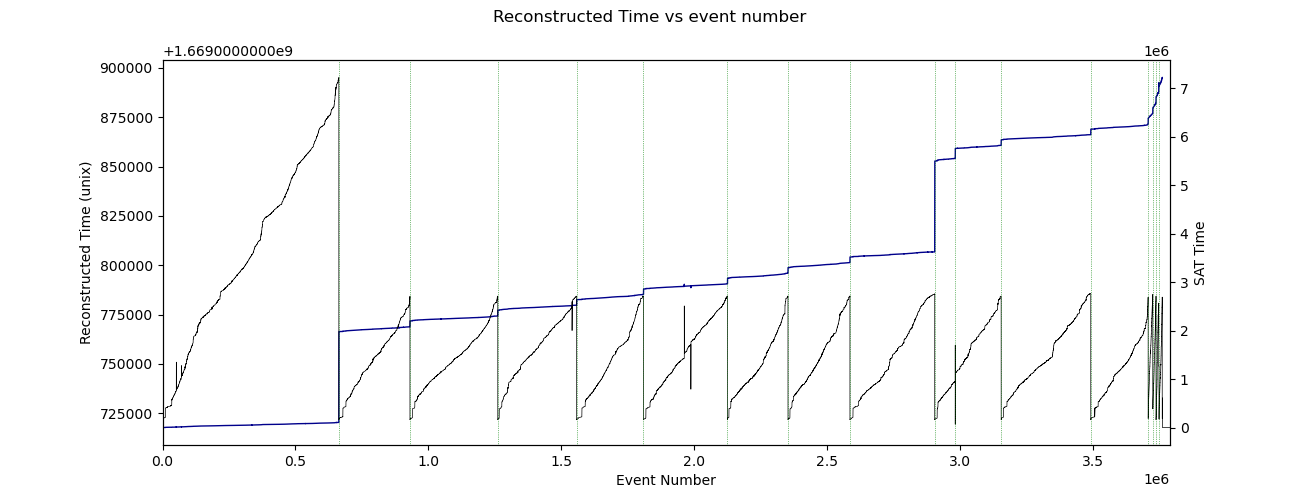

In [9]:
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

MIN = start_timestamps_idx[0]

ax1.plot(timestamp,c='darkblue',lw=1)
ax2.plot(data['stimestamp'][MIN:],lw=0.5,c='k')
for i in start_timestamps_idx:
    ax2.axvline(i - MIN,c='g',lw=0.5,ls=':')

ax1.set_ylabel('Reconstructed Time (unix)')
ax2.set_ylabel('SAT Time')
ax1.set_xlabel('Event Number')
ax2.set_xlim(0,len(data['stimestamp'][MIN:]))
fig.suptitle('Reconstructed Time vs event number')


# Let's calculate TGFs

In [10]:
# Plotting the energies
clipped_data                = rp.subdict(data,MIN,MIN+len(timestamp))
clipped_data['stimestamp']  = timestamp

# Charge Spectra

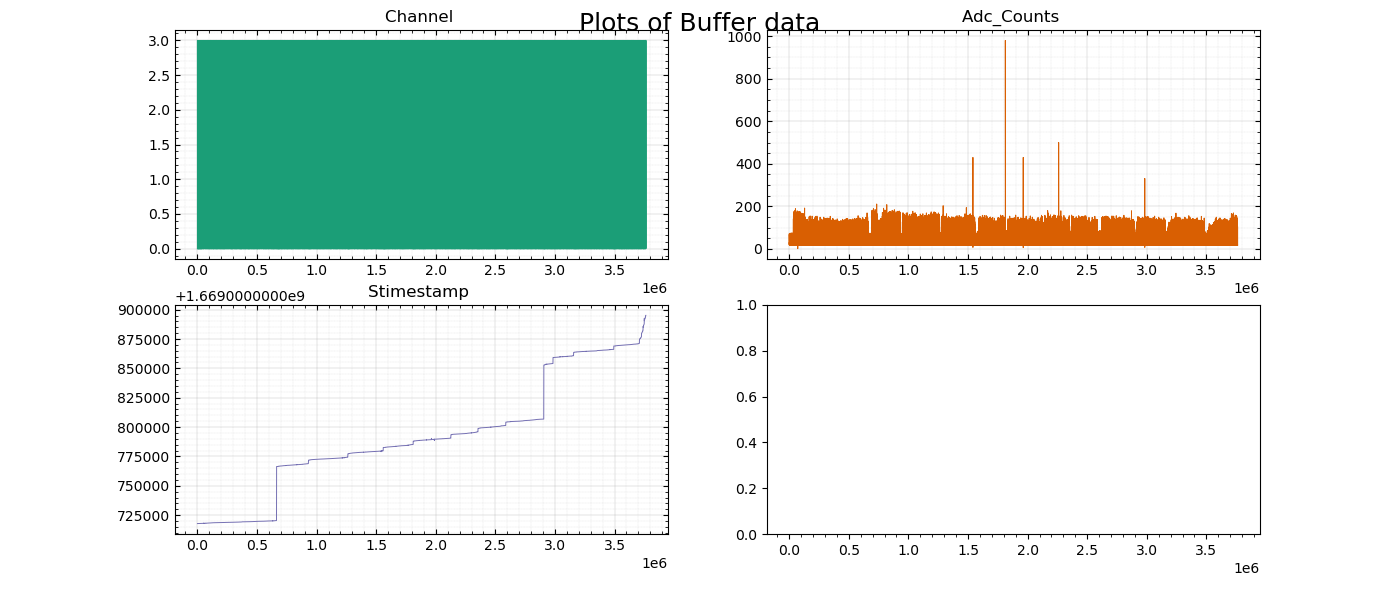

In [11]:
rp.plot_buffer(clipped_data);

Text(0, 0.5, 'ADC Counts')

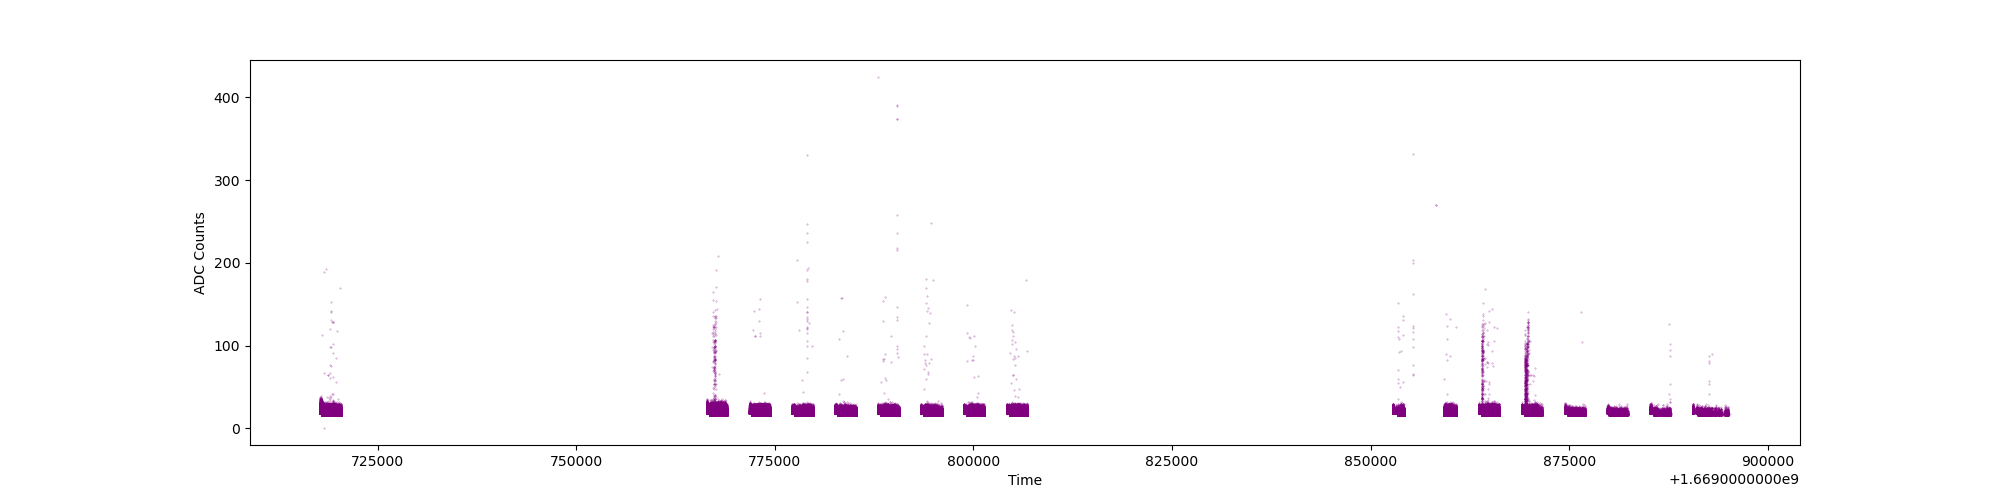

In [12]:
# Charge VS time
fig = plt.figure(figsize=(20,5))
ax  = fig.add_subplot(111)

channel_clipped,_ = rp.split_channels(clipped_data)

# Plot them as functions of time
ax.scatter(channel_clipped[0]['stimestamp'], channel_clipped[0]['adc_counts'], c='purple', s=0.1, alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('ADC Counts')



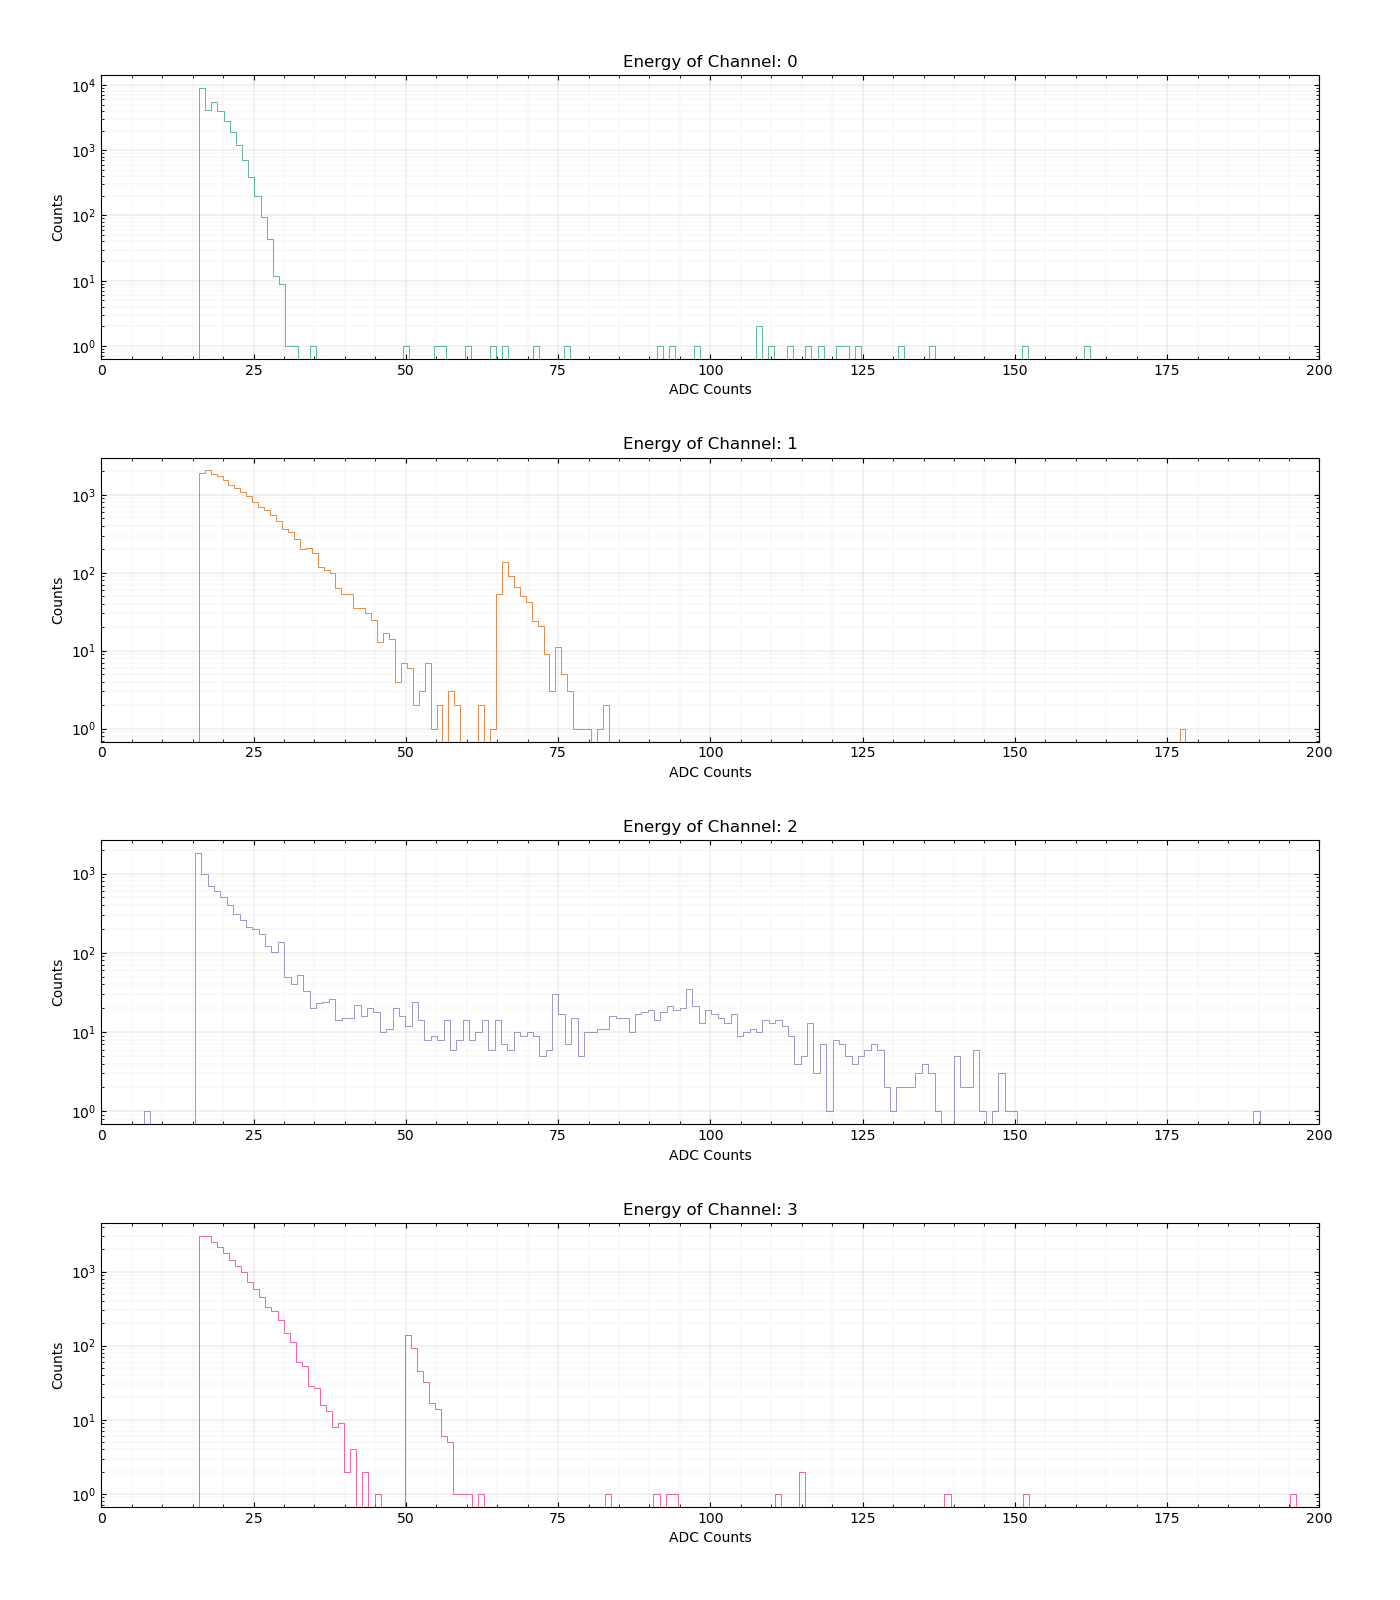

In [19]:
# Time indices
clipped_idx = np.where(np.array(1669852781 < clipped_data['stimestamp']) & np.array(clipped_data['stimestamp'] <1669855448))[0]

# Get the splitted channels
RANGE   = None
struct  = rp.NONVETO_STRUCT
bins    = 310  #830 #990
channels,idx = rp.split_channels(rp.subdict(clipped_data,min(clipped_idx),max(clipped_idx)),struct)

# Create a figure
fig,ax  = plt.subplots(len(channels),1,figsize=(14,4*len(channels)),dpi=100)
fig.tight_layout(pad=5)
ax      = ax.flatten()
colors  = rp.cm.get_cmap('Dark2').colors

# Get the maximum energy
ADC_max = max([max(channel['adc_counts']) for channel in channels])

calibration_peaks = [[[0,0],[403.6,10]],[[0,0],[427.8,10]],[[0,0],[323.9,10]],[[0,0],[422.0,10]]]

# Plot the histogram of each channel
for i,channel in enumerate(channels):
    # Calibrate
    x0 = calibration_peaks[i][0][0]
    x1 = calibration_peaks[i][1][0]
    e0 = calibration_peaks[i][0][1]
    e1 = calibration_peaks[i][1][1]
    a  = (e0-e1)/(x0-x1)
    b  = (e1*x0-e0*x1)/(x0-x1)
    
    # apply the calibration
    calibrated = channel['adc_counts']#*a + b

    ax[i].hist(calibrated,bins=int(bins/ADC_max*max(channel['adc_counts'])),range=RANGE,color=colors[i%len(channels)],fill=False,histtype='step',lw=0.5)

    ax[i].set_title('Energy of Channel: %d'%i)
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='both',which='both',direction='in',top=True,right=True)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].grid(axis='both', which='major', lw=0.25)
    ax[i].grid(axis='both', which='minor', lw=0.2, ls=':')
    ax[i].set_xlim(0,200)
    ax[i].set_ylabel('Counts')
    ax[i].set_xlabel('ADC Counts')


# Get the satellite position at those points

In [12]:
# Get the location of the cubesat in this time
positions = rp.get_light1_position(rp.Time(min(clipped_data['stimestamp']),format='unix'),rp.Time(max(clipped_data['stimestamp']),format='unix'),n_events=10000)

SELECT * FROM `LIGHT-1_Position_Data`.PositionData WHERE `Time (ModJDate)` BETWEEN 59912.31250017308 AND 59914.46744110309;


In [12]:
# rp.map(positions)

In [13]:
# Interpolate positionstrigger
def interpolate(array,timestamps):
    new_array       = [0]*len(timestamps)
    old_time        = array.get_timestamps(format='unix').astype('float64')
    longs,lats      = array.get_coords().T
    interp_longs    = np.interp(timestamps,old_time,longs),
    interp_lats     = np.interp(timestamps,old_time,lats),

    for i in rp.tqdm(range(len(timestamps))):
        new_array[i] = rp.event(
            timestamp = rp.Time(timestamps[i],format='unix'),
            latitude  = interp_lats[0][i],
            longitude = interp_longs[0][i],
            detector_id=0,
        )

    return rp.array(new_array)

positions = interpolate(positions,clipped_data['stimestamp'])

  0%|          | 0/3844707 [00:00<?, ?it/s]

In [33]:
idx = (np.random.sample(size=10000)*len(positions)).astype('int').tolist()
# rp.map(positions[idx])

In [16]:
# Obtain the coincidence statistics
def get_consecutive_timestamps(data, threshold:float=2e-4, time_units:float=1, remove_multiplicities:int = 1, remove_detectors:int = 1, SAA_skip:bool=True, latitudes=None, longitudes=None, lat_range=(-35,35), VERBOSE=True):
    """Gicen a set of data find the ones that have the same timestamp and return their frequency

    Args:
        data (dict): dataset
        gt (int, optional): Consider only timestamps with more coincidences than this number. Defaults to 0.
        lt (int, optional): Consider only timestamps with less coincidences than this number. Defaults to None.
        VERBOSE (bool, optional): Print statistics if you want to. Defaults to True.

    Returns:
        _type_: _description_
    """

    # list to hold the bunches
    bunches = []

    # The start point of the ramp
    current_bunch = None

    # For each datapoint in the data
    for i in rp.tqdm(range(len(data['stimestamp'])-1)):
        if (latitudes is not None) and  not (lat_range[0] <= latitudes[i] <= lat_range[1]): continue
        if SAA_skip and (-40 <= latitudes[i] <= -5) and (-80 <= longitudes[i] <= 0): continue
        # Check if the neighbors are within the threshold
        if abs(data['stimestamp'][i+1] - data['stimestamp'][i]) < threshold/time_units:
            # If the current bunch is empty then start it
            if current_bunch is None:
                current_bunch = {
                    'start_idx': i,
                    'cnt': 1
                }
            # Otherwise simply increase the count
            else:
                current_bunch['cnt'] += 1
        
        # If the difference is greater than the threshold
        else:
            # If there is no current bunch don't do anything
            if current_bunch is None: continue
            
            # Otherwise finish the bunch and add it
            else:
                # Add the final data 
                current_bunch['end_idx']    = i+1
                current_bunch['cnt']       += 1
                current_bunch['data']       = rp.dict_subsec(data,range(current_bunch['start_idx'],current_bunch['end_idx']))
                current_bunch['duration']   = float(max(current_bunch['data']['stimestamp']) - min(current_bunch['data']['stimestamp']))
                current_bunch['position']   = {
                    'longitudes': longitudes[current_bunch['start_idx']:current_bunch['end_idx']+1],
                    'latitudes' : latitudes [current_bunch['start_idx']:current_bunch['end_idx']+1]
                    }

                # Add the bunch to the bunches
                _, id, cnts = np.unique(current_bunch['data']['stimestamp'],return_index=True, return_counts=True)
                if (sum(cnts > remove_multiplicities)):
                    current_bunch['data'] = rp.dict_subsec(current_bunch['data'],id)
                    current_bunch['cnt']  = len(cnts)

                if (len(np.unique(current_bunch['data']['channel'])) > remove_detectors):# and (current_bunch['cnt'] == 3):
                    bunches.append(current_bunch)

                # Reset the bunch
                current_bunch = None
            
    # Print if needed
    if VERBOSE:
        print(rp.bcolors.HEADER+"Bunches found:"+rp.bcolors.ENDC+rp.bcolors.BOLD, len(bunches))
        # print(rp.bcolors.OKBLUE+'Count'+rp.bcolors.ENDC+rp.bcolors.BOLD+'\tTimestamp'+rp.bcolors.ENDC)
        # for bunch in bunches: print(rp.bcolors.OKBLUE+"%5d"%bunch['cnt']+rp.bcolors.ENDC+"\t%.1f"%np.mean(bunch['data']['stimestamp']))
            

    return bunches

In [17]:
bunches = get_consecutive_timestamps(clipped_data, threshold = 0.5e-3, longitudes = positions.get_coords().T[0], latitudes = positions.get_coords().T[-1] , VERBOSE = True)

  0%|          | 0/3928093 [00:00<?, ?it/s]

Bunches found: 223762


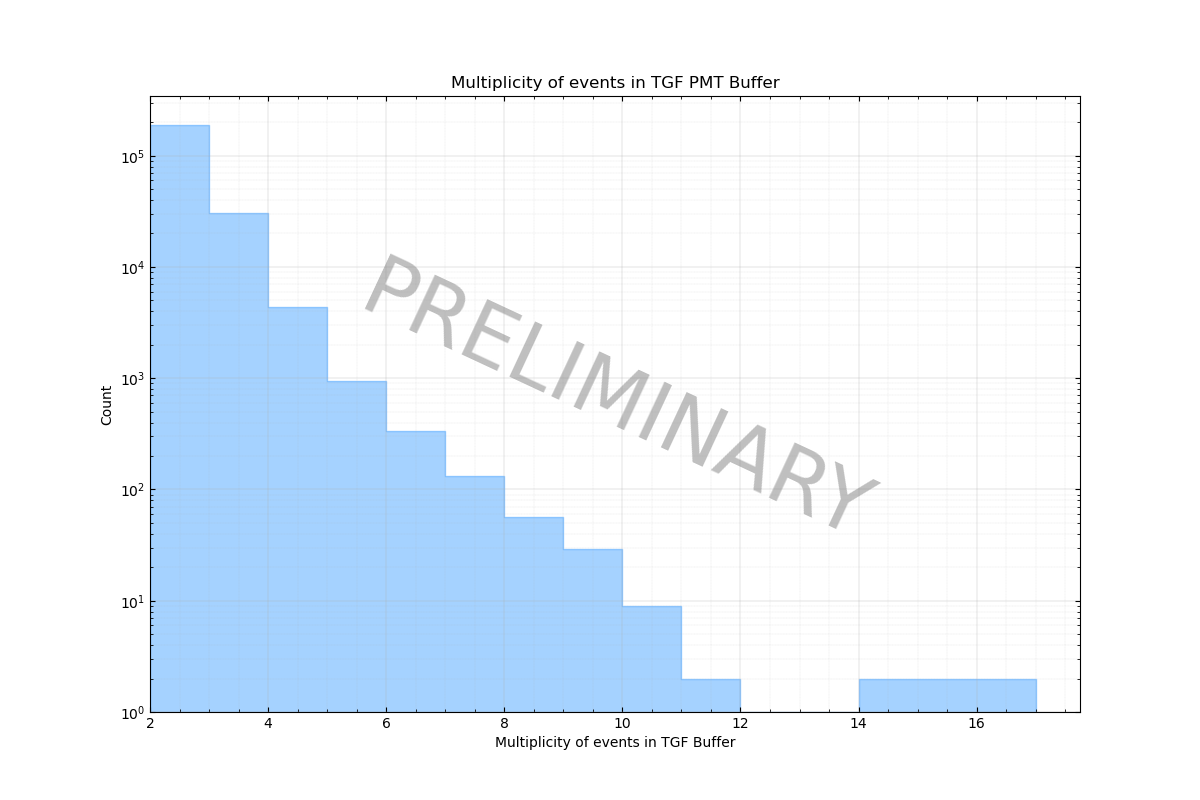

In [18]:
# Plot the batches distribution
def plot_bunches(bunches,log:bool=True):
    # Create a figure
    fig     = plt.figure(figsize=(12,8),dpi=100)
    ax      = fig.add_subplot(111)

    # Get the counts
    counts          = [batch['cnt'] for batch in bunches]
    unique, freq    = np.unique(counts, return_counts=True)

    # Plot it as a histogram
    # ax.step(unique,freq,where='post',c='rebeccapurple',lw=0.6,label='Histogram of coincidences')
    ax.fill_between(unique,freq,step="post",alpha = 0.4,color='dodgerblue')

    # Prettify
    ax.set_title('Multiplicity of events in TGF PMT Buffer')
    if log: ax.set_yscale('log')
    ax.set_ylim(1)
    ax.set_xlim(2)
    ax.tick_params(axis='both',which='both',direction='in',top=True,right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(axis='both', which='major', lw=0.25)
    ax.grid(axis='both', which='minor', lw=0.2, ls=':')
    ax.set_xlabel('Multiplicity of events in TGF Buffer')
    ax.set_ylabel('Count')
    # ax.legend(frameon=False)

    # WATERMARK
    ax.text(0.5, 0.5, 'PRELIMINARY', transform=ax.transAxes,
        fontsize=60, color='gray', alpha=0.5,
        ha='center', va='center', rotation='-25')

    return fig,ax

fig,ax = plot_bunches(bunches)

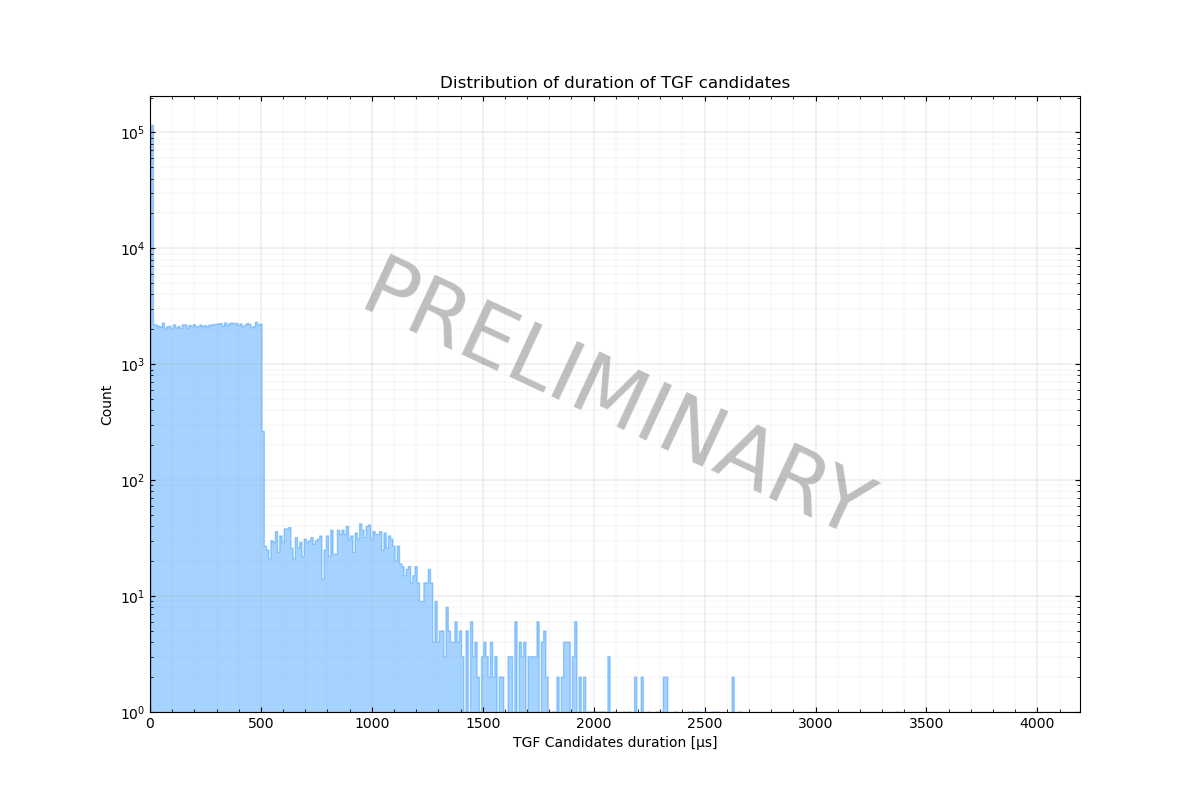

In [19]:
# Plot the batches distribution
def plot_bunches_duration(bunches,log:bool=True,bins:int=100):
    # Create a figure
    fig     = plt.figure(figsize=(12,8),dpi=100)
    ax      = fig.add_subplot(111)

    # Get the counts
    times           = [batch['duration']*1e6 for batch in bunches]
    hist, bin_edges = np.histogram(times,bins=bins)

    # Plot it as a histogram
    # ax.step((bin_edges[:-1] + bin_edges[1:])/2,hist,where='post',c='rebeccapurple',lw=0.6,label='Histogram of coincidences')
    ax.fill_between((bin_edges[:-1] + bin_edges[1:])/2,hist,step="post",alpha = 0.4,color='dodgerblue')

    # Prettify
    ax.set_title('Distribution of duration of TGF candidates')
    if log: ax.set_yscale('log')
    ax.set_ylim(1)
    ax.set_xlim(0)
    ax.tick_params(axis='both',which='both',direction='in',top=True,right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(axis='both', which='major', lw=0.25)
    ax.grid(axis='both', which='minor', lw=0.2, ls=':')
    ax.set_xlabel('TGF Candidates duration [μs]')
    ax.set_ylabel('Count')
    # ax.legend(frameon=False)

    # WATERMARK
    ax.text(0.5, 0.5, 'PRELIMINARY', transform=ax.transAxes,
        fontsize=60, color='gray', alpha=0.5,
        ha='center', va='center', rotation='-25')

    return fig,ax, hist,(bin_edges[:-1] + bin_edges[1:])/2

fig,ax, hist,times = plot_bunches_duration(bunches,log=True,bins=400)

512


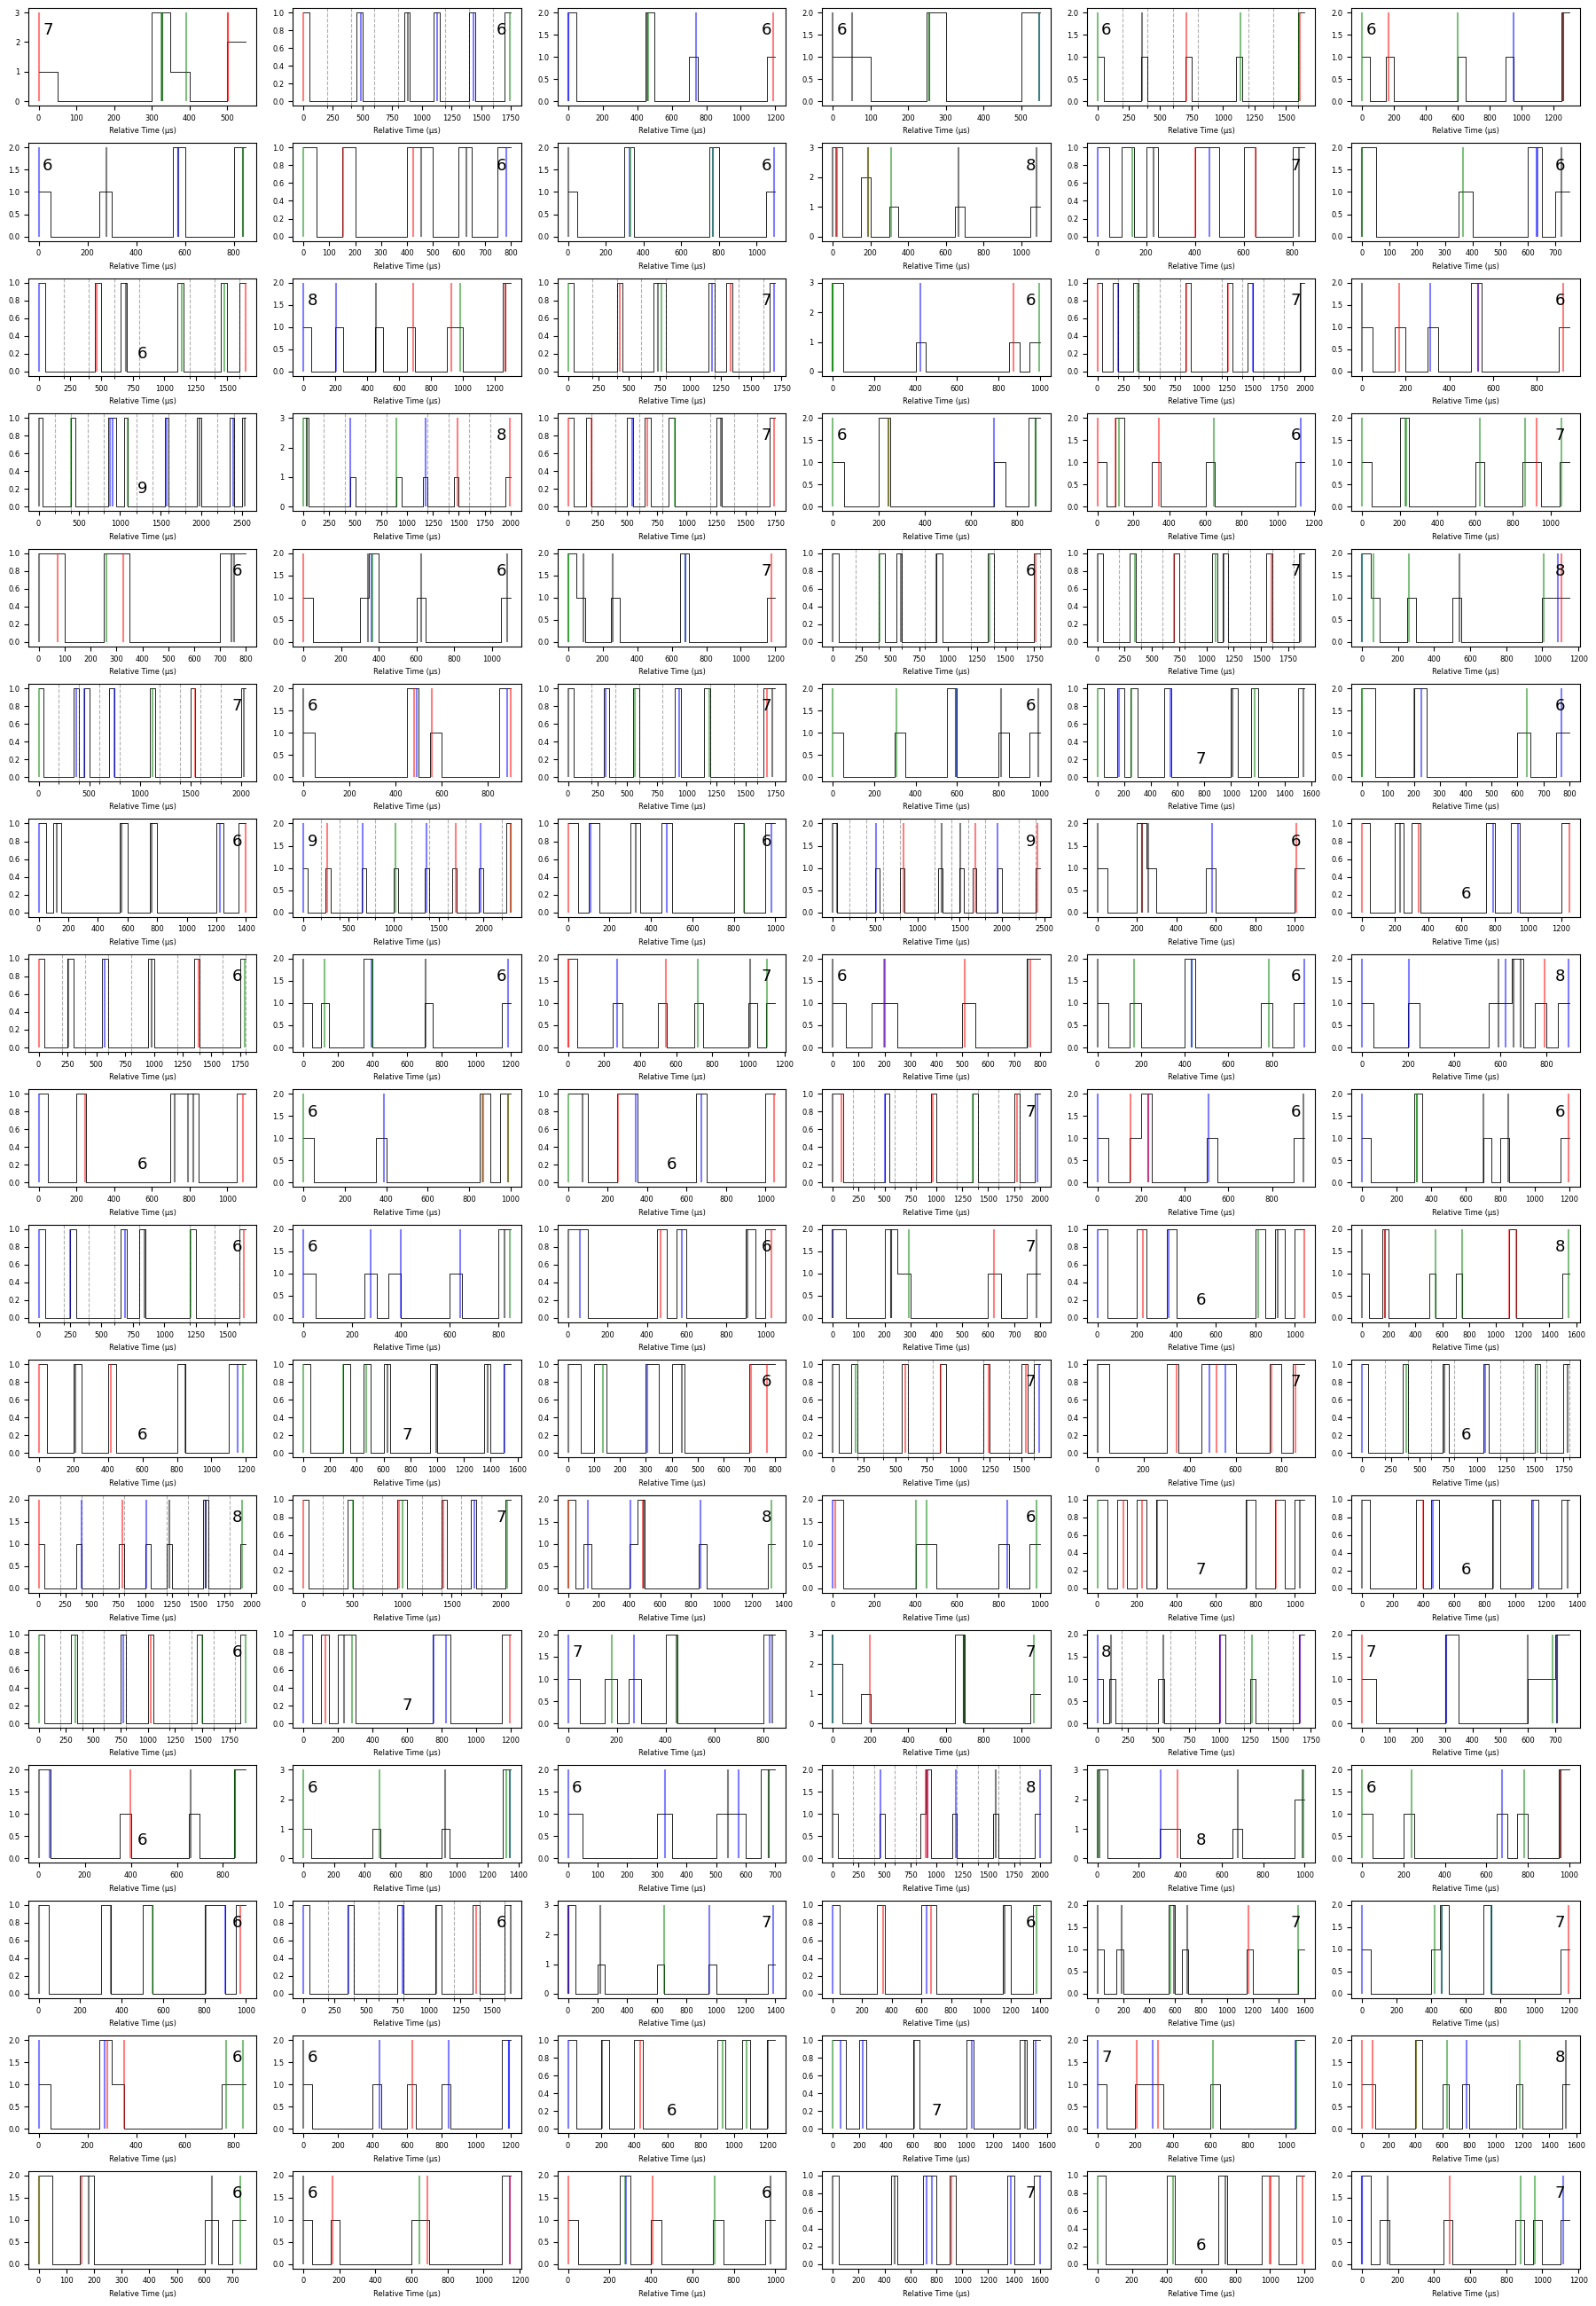

In [20]:
# PARAMETERS
N           = 102
SIZE_X      = 3
SIZE_Y      = 1.5
COLS        = 6
N_THRESHOLD = 5        # Number Threshold
T_THRESHOLD = 500.0
C_THRESHOLD = 1
BIN_WIDTH   = 50

# Selected Events
selected_events = np.array([batch for batch in bunches if batch['cnt'] > N_THRESHOLD and len(np.unique(batch['data']['channel'])) >= C_THRESHOLD and (T_THRESHOLD < batch['duration']*1e6 < 10*T_THRESHOLD)])
print(len(selected_events))
N = min(N,len(selected_events))
if N < len(selected_events): selected = np.random.choice(selected_events, N, replace=False)
else: selected = selected_events

# Fix fonts
plt.rcParams.update({'font.size': 6})

# Create a figure
fig, axes = plt.subplots(int(N+COLS/2)//COLS,COLS,figsize=(SIZE_X*COLS,SIZE_Y*(N+COLS/2)//COLS),dpi=100)
fig.subplots_adjust(top=0.95)
axes = axes.flatten()

colors = np.array(['r','g','b','k'])

# Plot each event ont it's own axis
for i,batch in enumerate(selected):

    # Get the data
    timestamps = (batch['data']['stimestamp'] - min(batch['data']['stimestamp']))*1e6
    channels   = batch['data']['channel']
    energies   = batch['data']['adc_counts']
    
    hist, bin_edges = np.histogram(timestamps,bins=np.arange(min(timestamps), max(timestamps) + BIN_WIDTH, BIN_WIDTH))

    # Plot
    # axes[i].scatter(timestamps,energies,s=10,c='k',marker='x',label='%d'%batch['cnt'])
    axes[i].step(bin_edges,np.append(hist,[hist[-1]]),where='post',c='k',lw=0.6)#,label='%d'%batch['cnt'])
    axes[i].vlines(timestamps,0,max(hist),color=[colors[int(i)] for i in channels],label='%d'%batch['cnt'],alpha=0.5)
    # axes[i].vlines((bin_edges[:-1] + bin_edges[1:])/2,0,hist,color='k',lw=1,label='%d'%batch['cnt'])

    # Prettify
    axes[i].set_xlabel('Relative Time (μs)')
    # axes[i].set_ylabel('Frequency')
    leg = axes[i].legend(frameon=False,handlelength=0, handletextpad=0,fontsize=13)
    for item in leg.legendHandles: item.set_visible(False)
    axes[i].xaxis.set_minor_locator(IndexLocator(base=200,offset=0))
    axes[i].grid(which='minor',axis='x',linestyle='--')


plt.tight_layout()

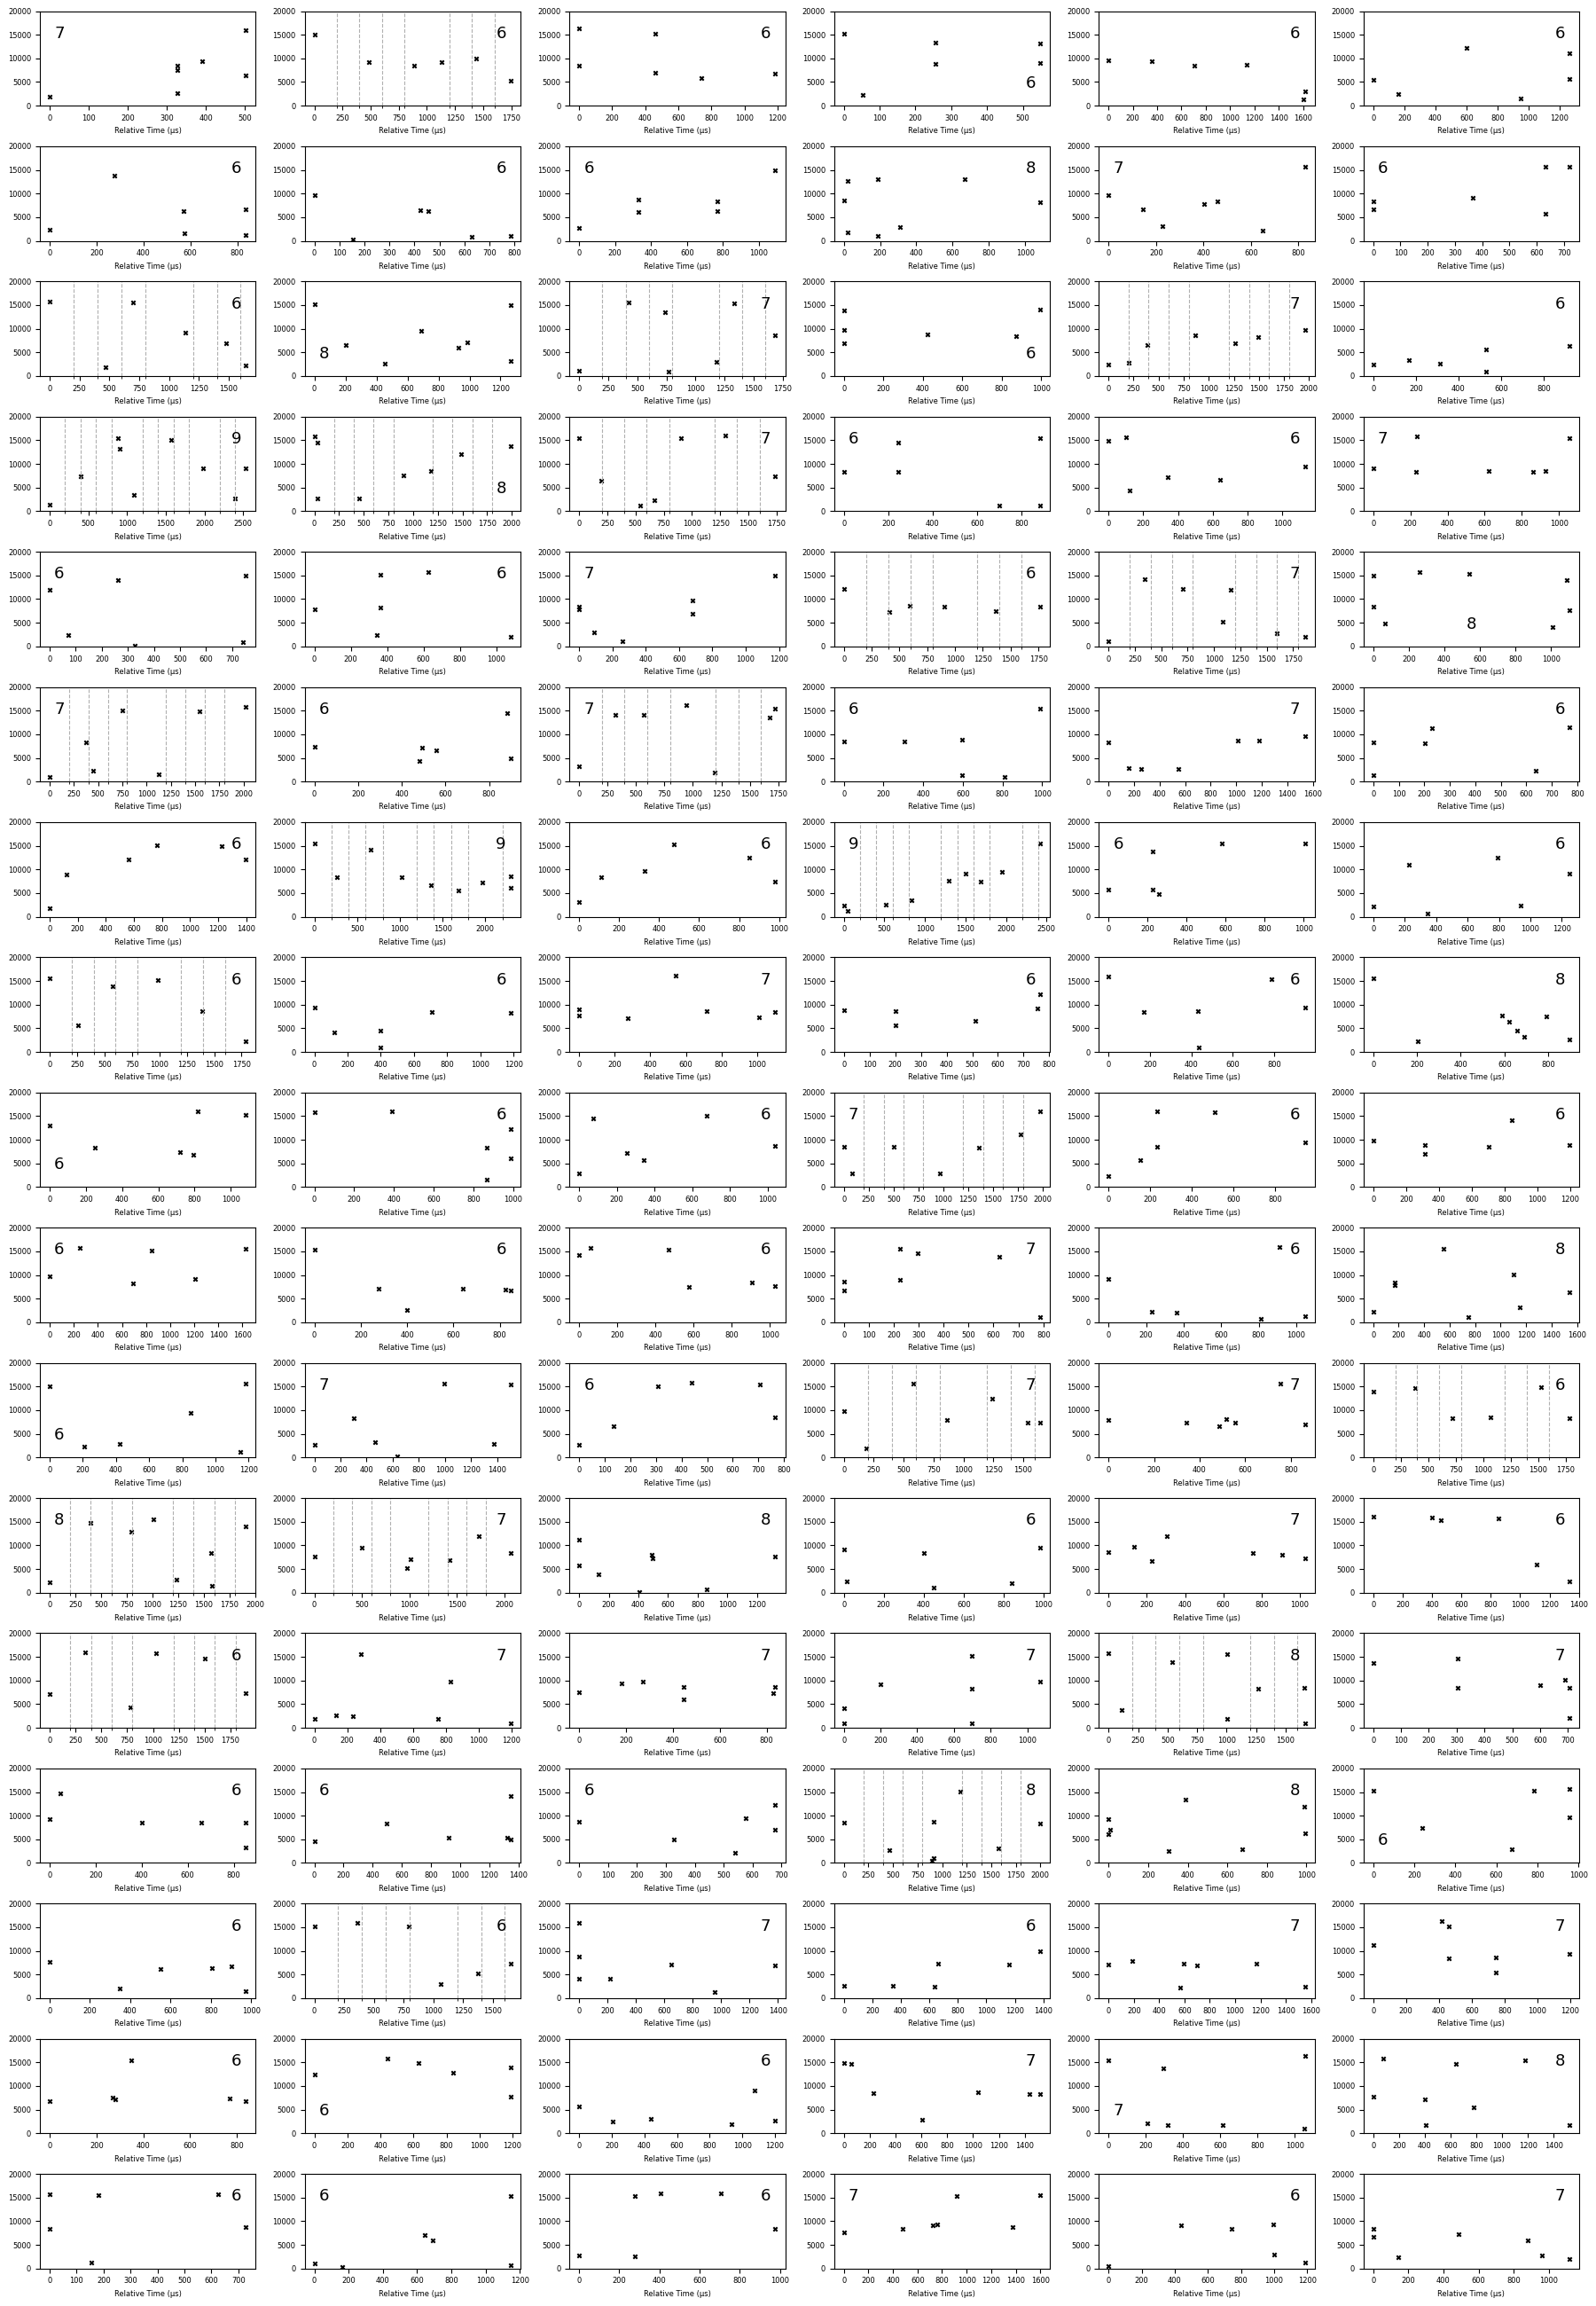

In [21]:
# Fix fonts
plt.rcParams.update({'font.size': 6})

# Create a figure
fig, axes = plt.subplots(int(N+COLS/2)//COLS,COLS,figsize=(SIZE_X*COLS,SIZE_Y*(N+COLS/2)//COLS),dpi=100)
fig.subplots_adjust(top=0.95)
axes = axes.flatten()

colors = np.array(['r','g','b','k'])

# Plot each event ont it's own axis
for i,batch in enumerate(selected):

    # Get the data
    timestamps = (batch['data']['stimestamp'] - min(batch['data']['stimestamp']))*1e6
    channels   = batch['data']['channel']
    energies   = batch['data']['adc_counts']
    
    hist, bin_edges = np.histogram(timestamps,bins=np.arange(min(timestamps), max(timestamps) + BIN_WIDTH, BIN_WIDTH))

    # Plot
    axes[i].scatter(timestamps,energies,s=10,c='k',marker='x',label='%d'%batch['cnt'])
    # axes[i].step(bin_edges,np.append(hist,[hist[-1]]),where='post',c='k',lw=0.6)#,label='%d'%batch['cnt'])
    # axes[i].vlines(timestamps,0,max(hist),color=[colors[int(i)] for i in channels],label='%d'%batch['cnt'],alpha=0.5)
    # axes[i].vlines((bin_edges[:-1] + bin_edges[1:])/2,0,hist,color='k',lw=1,label='%d'%batch['cnt'])

    # Prettify
    axes[i].set_xlabel('Relative Time (μs)')
    # axes[i].set_ylabel('Frequency')
    leg = axes[i].legend(frameon=False,handlelength=0, handletextpad=0,fontsize=13)
    for item in leg.legendHandles: item.set_visible(False)
    axes[i].xaxis.set_minor_locator(IndexLocator(base=200,offset=0))
    axes[i].grid(which='minor',axis='x',linestyle='--')
    axes[i].set_ylim(0,20000)


plt.tight_layout()

In [22]:
rp.Time(selected_events[-1]['data']['stimestamp'][0],format='unix').to_value('isot')

'2022-10-18T15:42:31.056'

In [23]:
min_time = rp.Time('2022-10-15T00:00:00.0',format='isot')
max_time = rp.Time('2022-10-18T00:00:00.0',format='isot')
idx = [b['start_idx'] for b in rp.tqdm(selected_events) if min_time.to_value('unix') <  positions[b['start_idx']].timestamp.to_value('unix') < max_time.to_value('unix') and not (rp.Time('2022-10-16T07:58:00.0',format='isot').to_value('unix') <  positions[b['start_idx']].timestamp.to_value('unix') < rp.Time('2022-10-16T08:05:00.0',format='isot').to_value('unix') )  and not (rp.Time('2022-10-17T00:14:00.0',format='isot').to_value('unix') <  positions[b['start_idx']].timestamp.to_value('unix') < rp.Time('2022-10-17T00:24:00.0',format='isot').to_value('unix') )]
print(len(selected_events),len(idx))
rp.map(positions[idx])

  0%|          | 0/512 [00:00<?, ?it/s]

512 16


In [24]:
raw_lights  = rp.get_lightning_strikes(min_time.to_value('isot'),max_time.to_value('isot'))
print(len(raw_lights))

  0%|          | 0/4 [00:00<?, ?it/s]

Day::   0%|          | 0/1657619 [00:00<?, ?it/s]

Day::   0%|          | 0/1657619 [00:00<?, ?it/s]

Day::   0%|          | 0/1657619 [00:00<?, ?it/s]

Day::   0%|          | 0/385 [00:00<?, ?it/s]

4973242


In [25]:
lights=raw_lights

In [26]:
# # Filter to the brightest lightnings
# LAST = int(0.5*len(raw_lights))

# currents = -raw_lights.get_property()
# idx_brightest=[]
# for i in rp.tqdm(range(LAST)):
#     idx__ = np.argmax(currents)
#     currents[idx__] *= -1
#     idx_brightest.append(idx__)

# lights = raw_lights[idx_brightest]

In [27]:
# Try and load cupy for cuda acceleration
try:
    print("Loading Cuda Cores")
    import cupy as cp
    print("Loaded Cuda Successfully")
except:
    import numpy as cp
    print(rp.bcolors.WARNING+"Cuda acceleration not available for your system"+rp.bcolors.ENDC)

Loading Cuda Cores
Loaded Cuda Successfully


In [28]:
def get_nearby_lightning(tgf,lightnings:rp.array,threshold:float=1,time:float=1,r:float=6378.1,c:float=299792458.0):
    """Given an array, or a single event object filter a raadpy array that contains lightnings within a threshold.

    Args:
        tgf (_type_): A single Event object, or an array of events of which to find the near lightnings
        lightnings (array): Raadpy array of lightnings of which to filter
        threshold (float, optional): Threshold in time to filter the lightings. Defaults to 1.

    Returns:
        lightnings (array): A filtered array of lightnings
    """

    # Convert the lightning positions to longitude and latitude
    print('Obtain the cartesian coordinates of the Lightnings')
    light_longs, light_lats = cp.asarray(lightnings.get_coords().T) /180 * np.pi

    # x,y,z From spherical to cartesian
    light_x = cp.cos(light_lats) * cp.cos(light_longs)
    light_y = cp.cos(light_lats) * cp.sin(light_longs)
    light_z = cp.sin(light_lats)
    light_t = cp.array([e.timestamp.to_value('unix') for e in lightnings.events])

    print('Lightning positions obtained successfully')

    # If you have given a single event return an array of them
    if type(tgf) == rp.event: tgf = rp.array([tgf])
    elif type(tgf) != rp.array: raise Exception("Type %s is not of type event, or array. Please use an object of type event or array for the tgf"%type(tgf))

    # Calculate the coordinates of the tgfs
    print('Obtain the cartesian coordinates of the TGFs')
    tgf_longs, tgf_lats = cp.asarray(tgf.get_coords().T) /180 * np.pi

    tgf_x = cp.cos(tgf_lats) * cp.cos(tgf_longs)
    tgf_y = cp.cos(tgf_lats) * cp.sin(tgf_longs)
    tgf_z = cp.sin(tgf_lats)
    tgf_t = cp.array([e.timestamp.to_value('unix') for e in tgf.events])

    print('TGF Candidate positions obtained successfully\nAttempting to calculate the spacetime distance')

    # Calculate the spacetime difference between everything
    # diff = [(cp.where(cp.sqrt((light_x - tx)**2 + (light_y - ty)**2 + (light_z - tz)**2 - (c*1e-3/r)**2 *(light_t - tt)*2) < (threshold/r))[0]).tolist() for tx,ty,tz,tt in rp.tqdm(zip(tgf_x,tgf_y,tgf_z,tgf_t),total=len(tgf))]
    diff = [(cp.where((cp.sqrt((light_x - tx)**2 + (light_y - ty)**2 + (light_z - tz)**2) < (threshold/r)) & (abs(light_t - tt) < time))[0]).tolist() for tx,ty,tz,tt in rp.tqdm(zip(tgf_x,tgf_y,tgf_z,tgf_t),total=len(tgf))]

    return diff

In [29]:
#Create random positions
ts      = np.random.rand(len(idx))*(positions[idx[-1]].timestamp.to_value('unix') - positions[idx[0]].timestamp.to_value('unix')) + positions[idx[0]].timestamp.to_value('unix')
lats    = np.random.rand(len(idx))*(35 + 35)-35
longs   = np.random.rand(len(idx))*(180 + 180)-180

random_pos = rp.array([rp.event(
    timestamp   = t,
    time_format ='unix',
    latitude    = lat,
    longitude   = long,
    detector_id = 0,
) for t,lat,long in zip(ts,lats,longs)])

In [30]:
increased_tgf = rp.array(positions[idx].events)

for i in range(len(increased_tgf)):
    increased_tgf[i].timestamp = increased_tgf[i].timestamp + rp.TimeDelta(60*60,format='sec')

In [31]:
rp.map(positions[idx])

In [32]:
diff = get_nearby_lightning(positions[idx],lights,threshold=500,time=1)
# diff = get_nearby_lightning(increased_tgf,lights,threshold=500)

Obtain the cartesian coordinates of the Lightnings
Lightning positions obtained successfully
Obtain the cartesian coordinates of the TGFs
TGF Candidate positions obtained successfully
Attempting to calculate the spacetime distance


  0%|          | 0/16 [00:00<?, ?it/s]

In [33]:
q=np.where([len(d) > 0  for d in diff])[0]
len(q)

0

In [34]:
rp.map(positions[[idx[a] for a in q]],lights[[diff[a][0] for a in q]],size=600)#.update_geos(projection_type="natural earth")
# rp.map(random_pos[q.tolist()],lights[[diff[a][0] for a in q]],size=1000).update_geos(projection_type="natural earth")

IndexError: index 0 is out of bounds for axis 0 with size 0

# Rate calculations

In [ ]:
# Filter timestamp
# This will remove all events in the SAA, and all events in the poles
# We can also filter out the repeated timestamps
longitudes, latitudes = positions.get_coords().T
lat_range = [-35,35]    # Removing data recorded over the poles
filtered_timestamp = np.unique([timestamp[i] for i in rp.tqdm(range(len(timestamp))) if (lat_range[0] <= latitudes[i] <= lat_range[1]) and (not ((-40 <= latitudes[i] <= -5) and (-80 <= longitudes[i] <= 0)))]) # Removing data recorded over the SAA as well


WINDOW_DURATION = 200e-3
hist, bin_edges = np.histogram(filtered_timestamp,bins=np.arange(min(filtered_timestamp), max(filtered_timestamp) + WINDOW_DURATION, WINDOW_DURATION))
# hist = hist/WINDOW_DURATION*1e-3
# hist = hist/WINDOW_DURATION

NameError: name 'positions' is not defined

In [ ]:
len(filtered_timestamp)/len(timestamp)

0.19124500791120044

In [ ]:
# Get rolling average of the histogram
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


# WINDOW 
WINDOW = 20

hist_av = moving_average(hist,n=WINDOW)

# WINDOW_SG   = 500
# POLY_ORDER  = 6

# hist_av = savgol_filter(hist_av, WINDOW_SG, POLY_ORDER)

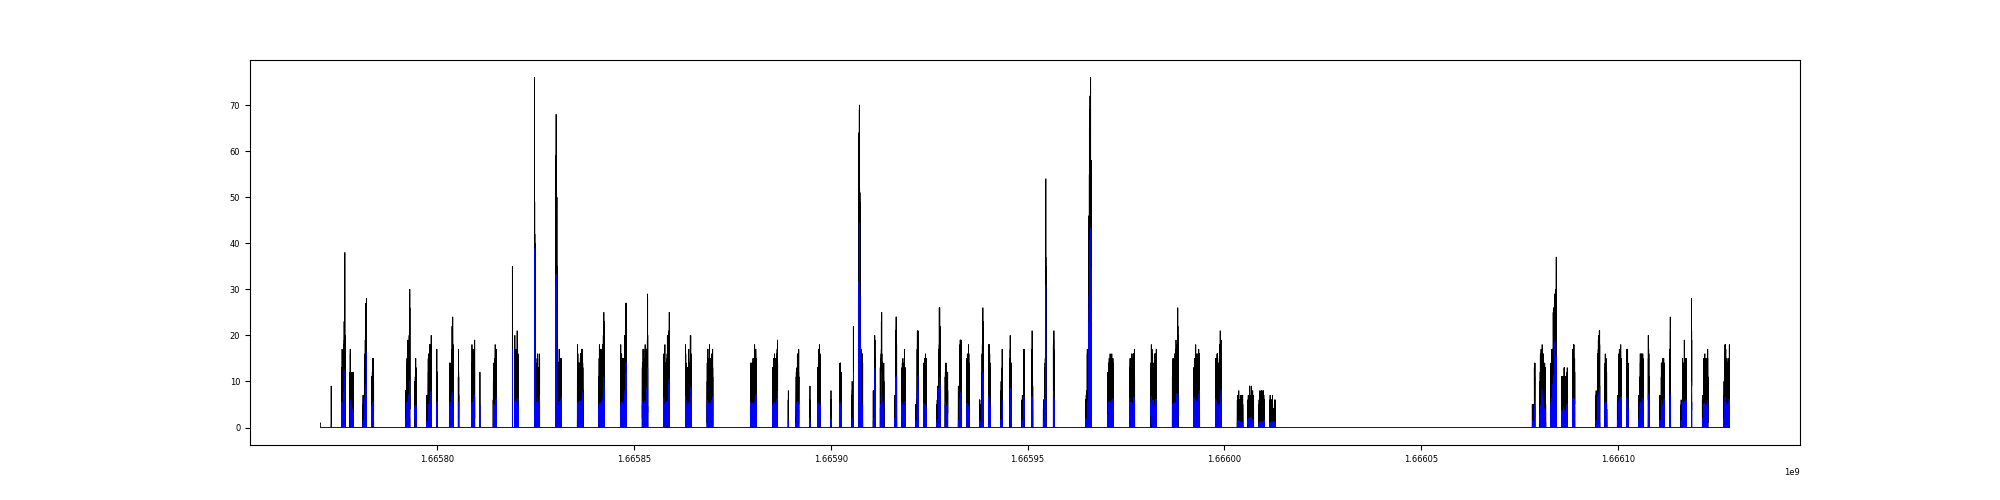

In [ ]:
plt.figure(figsize=(20,5))
plt.step(bin_edges,np.append(hist,[hist[-1]]),where='post',c='k',lw=0.6)#,label='%d'%batch['cnt'])
plt.plot(bin_edges[:len(hist_av)],hist_av,lw=0.5,c='b')
# for t in rp.tqdm(filtered_timestamp[:100000]):
#     plt.axvline(t,lw=0.01,ls='--',c='red')
plt.show()

Text(0, 0.5, 'Frequency')

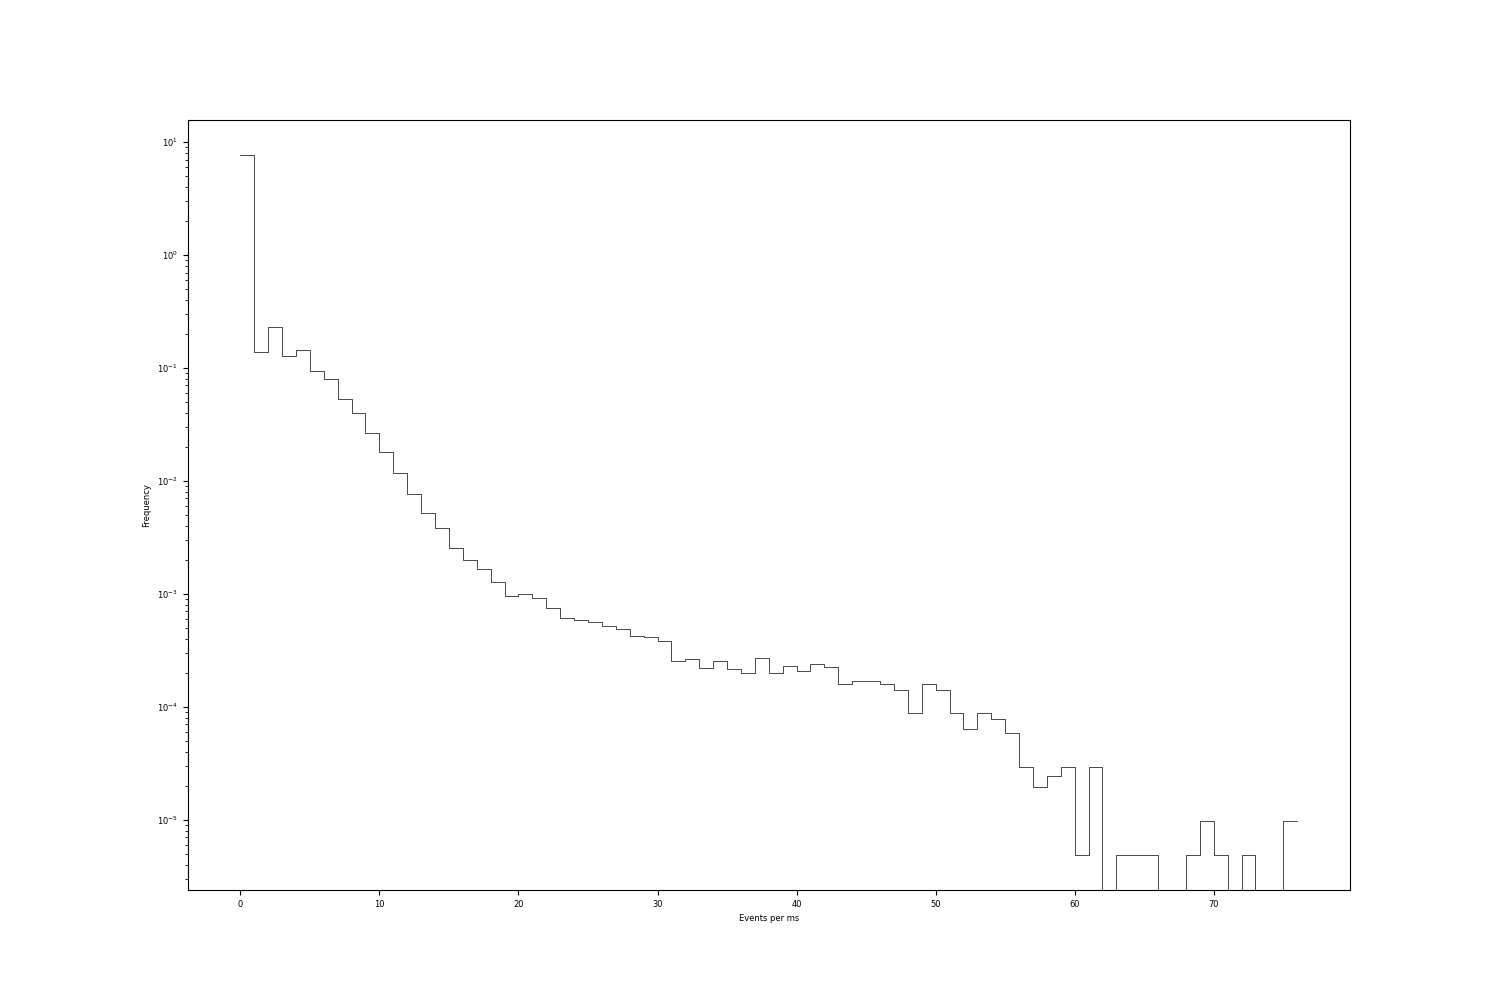

In [ ]:
BIN_WIDTH                   = 1 #0.005
rate_hist, rate_bin_edges   = np.histogram(hist,bins=np.arange(min(hist), max(hist) + BIN_WIDTH, BIN_WIDTH))
rate_hist                   = np.append(rate_hist,[rate_hist[-1]])/(np.sum(rate_hist[1:])*BIN_WIDTH)

plt.figure(figsize=(15,10))
plt.step(rate_bin_edges,rate_hist,where='post',c='k',lw=0.5)
plt.yscale('log')
plt.xlabel('Events per ms')
plt.ylabel('Frequency')
# plt.xlim(rate_bin_edges[1])

[2.33112325 6.01806154 0.53712763]


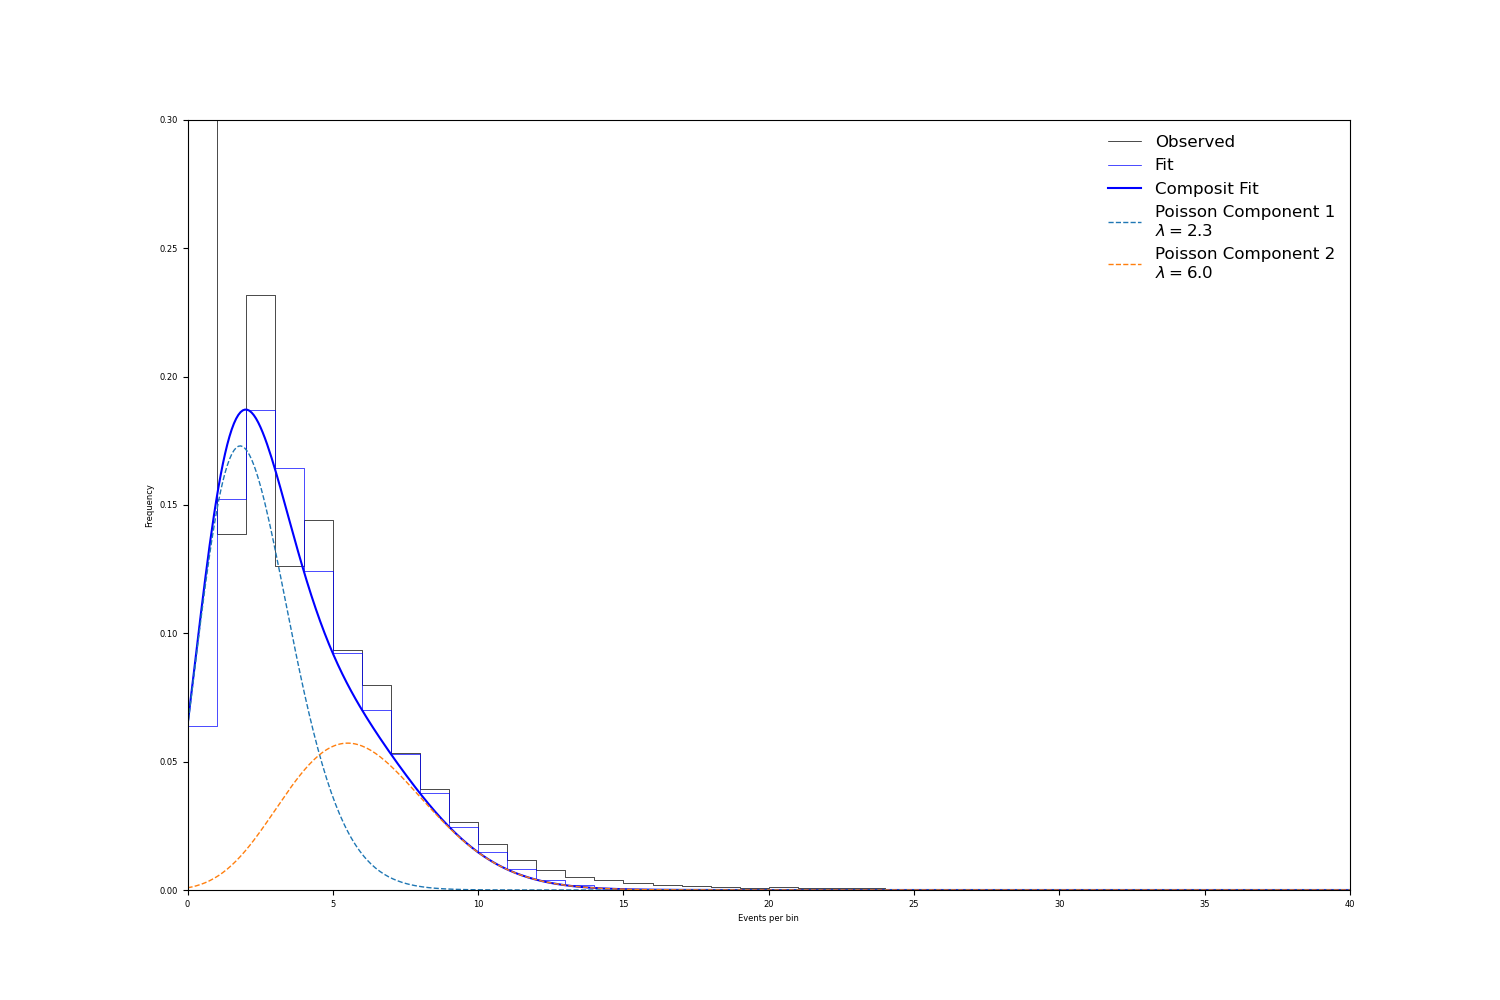

In [ ]:
# Fit two poissons
from scipy.special import factorial,gammaln
from scipy.optimize import curve_fit

# Poisson
log_poisson = lambda x,l: x * np.log(l) - l - gammaln(x+1)
log_gauss   = lambda x,m,s: -((x-m)**2/(2*s**2)) - 0.5*np.log(2*np.pi*s**2)

# Tell me how many poissons, I'll tell give you a function that models them
def get_model(n:int,m:int=0):
    
    function_str                 = 'lambda x,*p: ( (' + 'np.exp(log_poisson(x,p[0])) '+' '.join([f'+ p[{2*i+2}] * np.exp(log_poisson(x,p[{2*i+1}]))' for i in range(n-1)]) + ' '.join([f'+ p[{3*i+2+2*(n-1)+1}] * np.exp(log_gauss(x,p[{3*i+2*(n-1)+1}],p[{3*i+1+2*(n-1)+1}]))' for i in range(m)]) +f')' 
    if n>1 or m>0: function_str += '/(1 '+ ' '.join([f'+ p[{2*i+2}]' for i in range(n-1)]) + ' '.join([f'+ p[{3*i+2+2*(n-1)+1}]' for i in range(m)]) + ' )'
    function_str                += ')'
    # return function_str
    return eval(function_str)

def get_bounds(n:int,m:int):
    bounds = [max(rate_bin_edges)]

    for i in range(n-1): 
        bounds.append(max(rate_bin_edges))
        bounds.append(20)

    for i in range(m):
        bounds.append(max(rate_bin_edges))
        bounds.append(max(rate_bin_edges))
        bounds.append(20)

    return (0,bounds)


def get_norm(n,m,p):
    return 1 + sum([p[2*i+2] for i in range(n-1)]) + sum([p[3*i+2+2*(n-1)+1] for i in range(m)])

# Fit the data
n_poisson   = 2
n_gauss     = 0
model       = get_model(n_poisson,n_gauss)
p0          = np.array([2, 6,0.4])#, 13,10,0.1, 17,10,0.1])
bounds      = get_bounds(n_poisson,n_gauss)

FIT_RANGE   = np.array(list(range(1,50)))
popt, pcov  = curve_fit(model,rate_bin_edges[FIT_RANGE],rate_hist[FIT_RANGE],p0,bounds=bounds)#,method='dogbox',bounds=bounds)

rate_bin_interp = np.linspace(min(rate_bin_edges),max(rate_bin_edges),1000)

plt.figure(figsize=(15,10))
plt.step(rate_bin_edges,rate_hist,where='post',c='k',lw=0.5,label='Observed')
plt.step(rate_bin_edges,model(rate_bin_edges,*popt),where='post',c='b',lw=0.5,label='Fit')

norm = get_norm(n_poisson,n_gauss,popt)
plt.plot(rate_bin_interp,model(rate_bin_interp,*popt),c='b',lw=1.5,label='Composit Fit')

plt.plot(rate_bin_interp,1/norm*np.exp(log_poisson(rate_bin_interp,popt[0])),lw=1,ls="--",label='Poisson Component 1\n'+r'$\lambda = %.1f$'%popt[0])
for i in range(n_poisson-1): plt.plot(rate_bin_interp,popt[2*i+2]/norm*np.exp(log_poisson(rate_bin_interp,popt[2*i+1])),lw=1,ls="--",label=f'Poisson Component {i+2}\n'+r'$\lambda = %.1f$'%popt[2*i+1])
for i in range(n_gauss):     plt.plot(rate_bin_interp,popt[3*i+2+2*(n_poisson-1)+1]/norm*np.exp(log_gauss(rate_bin_interp,*popt[3*i+2*(n_poisson-1)+1:3*i+2+2*(n_poisson-1)+1])),lw=1,ls="--",label=f'Gaussian Component {i+1}\n'+r'$\mu = %.1f$'%popt[3*i+2*(n_poisson-1)+1])

# plt.yscale('log')
plt.xlabel('Events per bin')
plt.ylabel('Frequency')
plt.ylim(0,0.3)
plt.xlim(0,40)
plt.legend(frameon=False,fontsize=12)

print(popt)


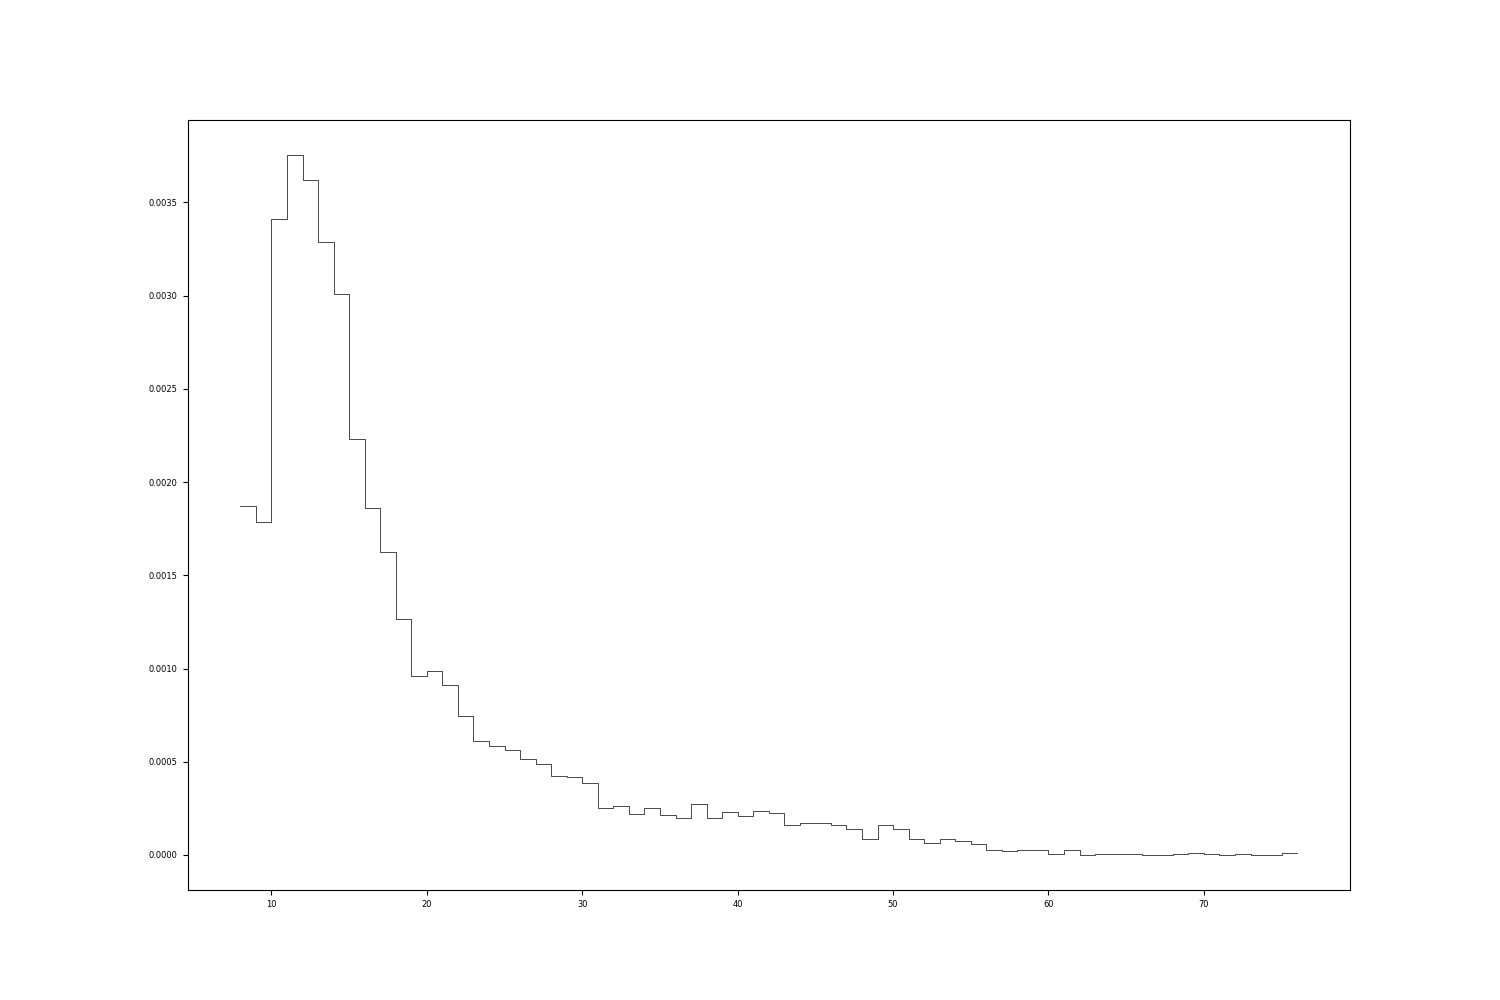

In [ ]:
plt.figure(figsize=(15,10))
min_bin = 8
plt.step(rate_bin_edges[min_bin:],rate_hist[min_bin:]-model(rate_bin_edges,*popt)[min_bin:],where='post',c='k',lw=0.5,label='Observed')

# Charge Map